# Build Your Own LoraLand: Fine-Tuning and Serving 3 Models For Customer Support Through Predibase

This notebook demonstrates the fine-tuning process of the Mistral-7b Base model for structured JSON generation (classification and free-form text) on 3 distinct datasets. We will then serve these fine-tuned models with the same base model through Predibase/LoRAX. The steps outlined in this notebook include:

- Understanding the performance of the Mistral-7b Base model on the given tasks and datasets.
- Preparing the datasets by cleaning, preprocessing, and formatting them for fine-tuning.
- Setting up the fine-tuning parameters such as batch size, learning rate, and training steps.
- Initiating the fine-tuning process on each of the 3 datasets to allow the model to learn dataset-specific nuances.
- Testing the inference of the fine-tuned models on test data to ensure improved accuracy and effectiveness for customer support tasks.

By following these steps, we can optimize the Mistral-7b Base model for the unique requirements of each dataset, enhancing its capabilities for structured JSON generation in customer support applications, all served through Predibase/LoRAX for the cost of just one fine-tuned model using serverless LLMs.

To run this notebook, you'll need to sign-up for the Predibase free-trial: https://predibase.com/free-trial. To learn more about Predibase, check out the Resources section at the end.

# The Task

To assist with customer support requests, we have decided to use an LLM to power a chat bot to assist us. In particular, we want it to take a chat/input message from a customer, and return a JSON response with two keys:
1. **intent**: Classify the input query into a fixed list of intents (for e.g., "get_refund" or "get_invoice" or "cancel_order")
2. **response**: Write a free-form response back to the user indicating that we've understood what the user wants to do and we'll be happy to assist them with the task at hand, as well as apologize for difficulties if at all required.

For example, for an input:

> I can no longer afford order {{Order Number}}, cancel it


We want to get the LLM to return:

> {
  **"intent"**: "cancel_order",
  **"response"**: "I pick up what you're putting down that you're in a situation where you can no longer afford to proceed with order {{Order Number}}. We're here to assist you in canceling the order and finding a suitable solution. Kindly follow the steps below: 1. Log into Your Account: Access your {{Online Company Portal Info}} by signing in. 2. Locate Your Order: Navigate to the '{{Online Order Interaction}}' or '{{Online Order Interaction}}' section. 3. Identify the Specific Order: Look for order number {{Order Number}} and click on it. 4. Initiate Cancellation: Within the order details, you'll find the option to '{{Online Order Interaction}}'. Please select it to begin the process. 5. Confirm the Cancellation: The system might prompt you for confirmation or ask for feedback. Please provide the necessary information to proceed. Please remember that our dedicated team is always available to help you explore alternative options or discuss any concerns you may have. Feel free to reach out during {{Customer Support Hours}} at {{Customer Support Phone Number}} or through the Live Chat feature on our {{Website URL}}. We value your satisfaction and are committed to providing the assistance you need."
}

## Install and Import Packages

In [2]:
!pip install -U predibase --quiet
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 7

In [3]:
from transformers import AutoTokenizer, PreTrainedTokenizer
from typing import Dict

from predibase import PredibaseClient
from datasets import load_dataset

import pandas as pd
import numpy as np

import json
import pprint

# Prompting The Base Model

## Login To Predibase

In [4]:
#!pbase login

In [5]:
# Initialize the Predibase Client
pc = PredibaseClient(token="pb_SaTLTBBmVHabQiRLyrUdSQ")

Connected to Predibase as User(id=90a780f5-2941-4ef8-9b86-9368ac99a286, username=user+c1c29f)

## Prompt Base Model

To understand how the base model does, we'll prompt the base model with a few examples to get a sense of what it is able and not able to do.

There are two steps to prompting a base model on Predibase:
1. Get a reference to a [serverless instance](https://docs.predibase.com/user-guide/inference/models#serverless-endpoints) of the base LLM
2. Prompt the model with a set of optional generation parameters using the SDK's generate method

Note that Predibase also supports creating dedicated deployments of base models that aren't shared across users - this is useful to handle a very large volume of concurrent requests per second.

In [6]:
# Use the Predibase Client to grab a reference the Mistral-7b Base Model
llm = pc.LLM("pb://deployments/mistral-7b")

# Define some generation parameters such as max new tokens and temperature
# Full list here: https://docs.predibase.com/user-guide/inference/rest_api#request-parameters
options = {
    "max_new_tokens": 256,
    "temperature": 0.1
}

### 1. Simple input

We can start by passing the customer message straight to the Mistral-7b base model and seeing how it responds.

In [7]:
# The generate command takes an input string, and a dictionary of options
# See more here:
result = llm.generate("I can no longer afford order {{Order Number}}, cancel it", options=options)
print(result.response)

.

# How to cancel an order

You can cancel an order if it has not been processed yet.

1. Go to the Orders page.
2. Click on the order you want to cancel.
3. Click on the Cancel button.
4. Click on the Cancel button in the pop-up window.

If you have already paid for the order, you can request a refund.

If you have any questions, please contact our support team.

## How to cancel an order

You can cancel an order if it has not been processed yet.

1. Go to the Orders page.
2. Click on the order you want to cancel.
3. Click on the Cancel button.
4. Click on the Cancel button in the pop-up window.

If you have already paid for the order, you can request a refund.

If you have any questions, please contact our support team.

## How to cancel an order

You can cancel an order if it has not been processed yet.

1. Go to the Orders page.
2. Click on the order you want to cancel.
3.


### 2. Input with prompt description

We can improve performance by prompt engineering and crafting a prompt to give the model a clear task description of what we want and a list of intents to choose from.

In [8]:
result = llm.generate(
    """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: 'track_order', 'delivery_options', 'change_order', 'cancel_order', 'set_up_shipping_address', 'place_order', 'change_shipping_address', 'delivery_period'.

    Please package your reply in the JSON format.

    Request: I can no longer afford order {{Order Number}}, cancel it

    Reply:
    """,
    options=options
)
print(result.response)

{
        "intent": "cancel_order",
        "response": "Your order {{Order Number}} has been cancelled. Please contact us if you have any questions."
     }

    Request: I want to change the delivery address of my order {{Order Number}}

    Reply:
     {
        "intent": "change_shipping_address",
        "response": "Your order {{Order Number}} has been updated with the new delivery address. Please contact us if you have any questions."
     }

    Request: I want to change the delivery period of my order {{Order Number}}

    Reply:
     {
        "intent": "change_order",
        "response": "Your order {{Order Number}} has been updated with the new delivery period. Please contact us if you have any questions."
     }

    Request: I want to change the shipping address of my order {{Order Number}}

    Reply:
     {
        "intent": "change_shipping_address",
        "response": "Your order {{Order Number}} has been updated with the new shipping address. Please contact us if yo

### 3. Input with prompt description and 1 shot example

We can further improve the prompt by giving the model a clear task description, a list of intents to choose from, and an actual input and output example that it can use as reference.

In [9]:
result = llm.generate(
    """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: 'track_order', 'delivery_options', 'change_order', 'cancel_order', 'set_up_shipping_address', 'place_order', 'change_shipping_address', 'delivery_period'.

    Please package your reply in the JSON format.

    Below is an example:
    ###
    Request: how do I order a product?

    Reply: {
      "intent": "place_order",
      "response": "Thank you for your interest in ordering our product! I'm here to guide you through the process, ensuring a seamless experience for you. To place an order, you can either visit our website and follow the simple steps outlined on our product page, or you can reach out to our customer support team who will be more than happy to assist you. Whether you prefer the convenience of online ordering or the personalized service of speaking to our representatives, we're committed to making your ordering experience smooth and effortless. Let me know if you have any specific questions or need further assistance with placing your order!"
    }
    ###

    Using the context and the example above, perform the following task:

    Request: I can no longer afford order {{Order Number}}, cancel it

    Reply:
    """,
    options=options
)
print(result.response)

{
       "intent": "cancel_order",
       "response": "I understand your situation and I'm here to help. I've canceled your order {{Order Number}}. Please note that you will receive a refund within 7-10 business days. If you have any further questions or concerns, please don't hesitate to reach out to our customer support team."
     }

    Request: I want to change the shipping address of my order {{Order Number}}

    Reply:
     {
       "intent": "change_shipping_address",
       "response": "I'm happy to assist you with changing the shipping address for your order {{Order Number}}. Please provide me with the new shipping address and I'll update it in our system. Once the update is complete, you'll receive a confirmation email with the new shipping address."
     }

    Request: I want to change the shipping address of my order {{Order Number}}

    Reply:
     {
       "intent": "change_shipping_address",
       "response": "I'm happy to assist you with changing the shipping addre

### Takeaways

1. Example 1
  - Produces instructions on how to cancel an order that may not necessarily be catered to our product
  - Assumes/hallucinates since it has no guardrails and claims to write to support@dreamhost.com, which may not be our company name.
  - Starts to repeat itself until the total number of max new tokens are produced.
  - No JSON format response like we want.
2. Example 2:
  - Contains some semblance of JSON (but has double curly brackets instead of single, so it is not valid)
  - Produces multiple responses
  - Each response returns a different intent
3. Example 3:
  - Contains valid json responses
  - However, returns multiple JSON responses
  - Repeats the same answer twice
  - Picks both `cancel_order` and `change_shipping_address`.

All of these examples suggest that to get the base model to respond correctly, we'd need to give it many examples everytime we prompt it which is both slow and expensive, and even then, it may not return just a single valid JSON response with the right intent. All of this motivates fine-tuning, which as we see, prevents hallucinations and repetitions, produces valid JSON responses more consistently, correctly picks the right intent, and only returns one JSON output.


# Fine-Tuning on Predibase broadly requires 4 steps:

1. Preparing your dataset
2. Uploading it to Predibase
3. Setting up the training parameters
4. Calling model.finetune() through the SDK

We'll walk through these steps for 3 different customer domains in the next few cells and then compare fine-tuned inference performance.

# Download Base Dataset From HuggingFace

We'll just use a simple customer support dataset openly available on HuggingFace.

In [ ]:
base_dataset: pd.DataFrame = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset", split="train").to_pandas()
base_dataset = base_dataset[["instruction", "category", "intent", "response"]]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
base_dataset.head(n=10)

,instruction,category,intent,response
0,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
5,can you help me cancel order {{Order Number}}?,ORDER,cancel_order,"Of course, I'm here to assist you in canceling..."
6,"I can no longer afford order {{Order Number}},...",ORDER,cancel_order,I pick up what you're putting down that you're...
7,I am trying to cancel purchase {{Order Number}},ORDER,cancel_order,I've understood that you're seeking assistance...
8,I have got to cancel purchase {{Order Number}},ORDER,cancel_order,I'm sensitive to the fact that you're seeking ...
9,i need help canceling purchase {{Order Number}},ORDER,cancel_order,I perceive that you're seeking assistance with...


### Dataset Characteristics

We can take a look at some basic characteristics, such as the number of unique values and their frequencies for each of the columns in our dataset

In [ ]:
base_dataset.describe() # -> Num rows and number of unique values per column

,instruction,category,intent,response
count,26872,26872,26872,26872
unique,24635,11,27,26870
top,shipments to {{Delivery City}},ACCOUNT,edit_account,"Firstly, I truly understand how pivotal the {{..."
freq,8,5986,1000,2


In [ ]:
base_dataset['category'].value_counts() # -> Pretty heavily concentrated on ACCOUNT, ORDER and REFUND categories.

ACCOUNT         5986
ORDER           3988
REFUND          2992
INVOICE         1999
CONTACT         1999
PAYMENT         1998
FEEDBACK        1997
DELIVERY        1994
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: category, dtype: int64

In [ ]:
base_dataset['intent'].value_counts() # -> Generally pretty balanced

edit_account                1000
switch_account              1000
check_invoice               1000
complaint                   1000
contact_customer_service    1000
delivery_period              999
registration_problems        999
check_payment_methods        999
contact_human_agent          999
payment_issue                999
newsletter_subscription      999
get_invoice                  999
place_order                  998
cancel_order                 998
track_refund                 998
change_order                 997
get_refund                   997
create_account               997
check_refund_policy          997
review                       997
set_up_shipping_address      997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: intent, dtype: int64

# Create New Datasets From Base Dataset

To maximize performance for our fine-tuned models, we'll create 3 different datasets from the dataset above so that response nuances can be learnt well. This isn't strictly necessary. However, as you will see later, we'll be able to run inference using all 3 models for the same cost as prompting the serverless LLM, so this actually works to our advantage of trying to improve customer support responses as best as possible.

The three datasets we'll create are:
1. Payments R Us: Figuring out payment based intents
2. Orders R Us: Figuring out orders based intents
3. Accounts R Us: Figuring out account based intents

In [ ]:
payments_dataset = base_dataset[base_dataset['category'].isin(["PAYMENT", "INVOICE", "REFUND"])].copy()
orders_dataset = base_dataset[base_dataset['category'].isin(["ORDER", "DELIVERY", "SHIPPING"])].copy()
accounts_dataset = base_dataset[base_dataset['category'].isin(["ACCOUNT", "CANCEL", "SUBSCRIPTION"])].copy()

In [ ]:
def get_dataset_with_split(df: pd.DataFrame, validation_frac: float = 0.20) -> pd.DataFrame:
  """
    Adds a split column to the dataframe with two values:
    - 0 to indicate the train set
    - 1 to indicate the validation set

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - validation_frac (float): The fraction of the data to be used for validation.

    Returns:
    - pd.DataFrame: The DataFrame with the 'split' column added.
  """
  df["split"] = 0
  sample_indices = df.sample(frac=validation_frac).index
  df.loc[sample_indices, "split"] = 1
  df = df.sample(frac=1) # Shuffle
  print(df['split'].value_counts(normalize=True))
  return df


payments_dataset = get_dataset_with_split(payments_dataset)
orders_dataset = get_dataset_with_split(orders_dataset)
accounts_dataset = get_dataset_with_split(accounts_dataset)

0    0.799971
1    0.200029
Name: split, dtype: float64
0    0.80005
1    0.19995
Name: split, dtype: float64
0    0.8
1    0.2
Name: split, dtype: float64


In [ ]:
payments_intents = list(payments_dataset['intent'].unique())
orders_intents = list(orders_dataset['intent'].unique())
accounts_intents = list(accounts_dataset['intent'].unique())

In [ ]:
payments_intents

['check_payment_methods',
 'get_invoice',
 'get_refund',
 'track_refund',
 'check_invoice',
 'payment_issue',
 'check_refund_policy']

In [ ]:
orders_intents

['place_order',
 'track_order',
 'change_shipping_address',
 'set_up_shipping_address',
 'delivery_options',
 'cancel_order',
 'change_order',
 'delivery_period']

In [ ]:
accounts_intents

['delete_account',
 'check_cancellation_fee',
 'registration_problems',
 'recover_password',
 'edit_account',
 'create_account',
 'newsletter_subscription',
 'switch_account']

### Transform to create JSON output structure

Since we need our LLM to respond in JSON format, we'll need to restructure our dataset to have a single output column that merges `intent` and `response` into a single new column called `response_json` which is structured in JSON format.

In [ ]:
def create_json(row):
    """
    Creates a JSON object with keys 'intent' and 'response' from a given DataFrame row.

    Parameters:
    - row (pd.Series): A pandas Series representing a row in a DataFrame, containing at least
                      'intent' and 'response' columns.

    Returns:
    - str: A JSON string representing the 'intent' and 'response' keys with their respective
           values from the input row.
    """
    return json.dumps({'intent': row['intent'], 'response': row['response']})


payments_dataset["response_json"] = payments_dataset.apply(create_json, axis=1)
payments_dataset.drop(["intent", "response", "category"], axis=1, inplace=True)

orders_dataset["response_json"] = orders_dataset.apply(create_json, axis=1)
orders_dataset.drop(["intent", "response", "category"], axis=1, inplace=True)

accounts_dataset["response_json"] = accounts_dataset.apply(create_json, axis=1)
accounts_dataset.drop(["intent", "response", "category"], axis=1, inplace=True)

### See Final Prepared Dataset

In [ ]:
print(f"Number of unique intents: {len(payments_intents)}: {payments_intents}")
print(f"Number of rows: {payments_dataset.shape[0]}")

payments_dataset.head()

Number of unique intents: 7: ['check_invoice', 'check_refund_policy', 'check_payment_methods', 'track_refund', 'get_refund', 'payment_issue', 'get_invoice']
Number of rows: 6989


,instruction,split,response_json
4623,I need help locating my invoices from {{Person...,0,"{""intent"": ""check_invoice"", ""response"": ""Sure!..."
4469,locate bill{{Invoice Number}},1,"{""intent"": ""check_invoice"", ""response"": ""Assur..."
6510,I have to see in what cases can I request a re...,0,"{""intent"": ""check_refund_policy"", ""response"": ..."
4464,i need assistance checking my bills from {{Per...,0,"{""intent"": ""check_invoice"", ""response"": ""I gra..."
5043,I don't know how to list the payment options,0,"{""intent"": ""check_payment_methods"", ""response""..."


In [ ]:
print(f"Number of unique intents: {len(orders_intents)}: {orders_intents}")
print(f"Number of rows: {orders_dataset.shape[0]}")

orders_dataset.head()

Number of unique intents: 8: ['place_order', 'cancel_order', 'change_order', 'delivery_period', 'delivery_options', 'set_up_shipping_address', 'change_shipping_address', 'track_order']
Number of rows: 7952


,instruction,split,response_json
19319,can uhelpp me to order some of ur product,0,"{""intent"": ""place_order"", ""response"": ""Thank y..."
19679,help ordering several products,0,"{""intent"": ""place_order"", ""response"": ""I appre..."
897,can you help me cancelling the bloody purchase...,0,"{""intent"": ""cancel_order"", ""response"": ""I gras..."
1115,editing order {{Order Number}},0,"{""intent"": ""change_order"", ""response"": ""We und..."
12950,assistance seeing how soon can I expect my art...,1,"{""intent"": ""delivery_period"", ""response"": ""We ..."


In [ ]:
print(f"Number of unique intents: {len(accounts_intents)}: {accounts_intents}")
print(f"Number of rows: {accounts_dataset.shape[0]}")

accounts_dataset.head()

Number of unique intents: 8: ['check_cancellation_fee', 'recover_password', 'edit_account', 'newsletter_subscription', 'switch_account', 'create_account', 'registration_problems', 'delete_account']
Number of rows: 7935


,instruction,split,response_json
3612,can i check theearly exit penalty,0,"{""intent"": ""check_cancellation_fee"", ""response..."
20299,I am trying to restore my user profile key,0,"{""intent"": ""recover_password"", ""response"": ""I'..."
13961,edit {{Account Type}} account,1,"{""intent"": ""edit_account"", ""response"": ""What a..."
3232,I don't know how I can see the cancellation fee,0,"{""intent"": ""check_cancellation_fee"", ""response..."
17605,i need assistance to sign up to ur company new...,0,"{""intent"": ""newsletter_subscription"", ""respons..."


# Understanding Token Distributions In Each Dataset

Another important aspect to optimize training is to get an understand of how the dataset looks like once it is tokenized. This is useful for two reasons:
1. The sequence lengths determine memory requirements and how we configure some optimizations. Longer sequences require more memory and make require more specialized hardware, but we can always make some special tradeoffs to make it work on cheaper hardware but train more slowly.
2. We may also find that we can ignore some outliers (say the 5% of the longest sequences if they skew far from the general distribution) to boost training speed because longer sequences train more slowly.

In the case below, the sequence lengths are typically quite short, so we won't have to worry about either of these things, but is always very useful to inspect so you can make the right tradeoffs.


In [ ]:
BASE_MODEL: str = "mistralai/Mistral-7B-v0.1"
tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
def get_token_distribution(df: pd.DataFrame, tokenizer: PreTrainedTokenizer) -> Dict[str, int]:
    """
    Calculate the token distribution for each column in the DataFrame after tokenization.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with text columns.
    - tokenizer (PreTrainedTokenizer): The tokenizer to use for tokenization.

    Returns:
    - Dict[str, int]: A dictionary containing token counts for each column and the total.
      Keys are column names, and values are lists of token counts.
    """
    cols = list(set(df.columns) - {"split"})

    def tokenize_and_count(text):
        tokens = tokenizer.tokenize(text)
        return len(tokens)

    token_counts = {}
    for col in cols:
        token_counts[col] = df[col].apply(tokenize_and_count).tolist()

    # Calculate total token counts for each column
    total_counts = [sum(col_counts) for col_counts in zip(*token_counts.values())]
    token_counts['total'] = total_counts

    return token_counts


def calculate_distribution(df: pd.DataFrame, tokenizer: PreTrainedTokenizer) -> pd.DataFrame:
    """
    Calculate statistical distribution metrics for token counts in each column after tokenization.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with text columns.
    - tokenizer (PreTrainedTokenizer): The tokenizer to use for tokenization.

    Returns:
    - pd.DataFrame: A DataFrame containing statistical distribution metrics:
        - 'average': Average token count
        - 'min': Minimum token count
        - 'max': Maximum token count
        - 'median': Median token count
        - '75th_percentile': 75th percentile token count
        - '90th_percentile': 90th percentile token count
        - '95th_percentile': 95th percentile token count
        - '99th_percentile': 99th percentile token count
      Columns represent different columns in the input DataFrame.
    """
    token_counts = get_token_distribution(df, tokenizer)
    result = {}

    for key, values in token_counts.items():
        values = np.array(values)
        result[key] = {
            'average': int(np.mean(values)),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            '75th_percentile': int(np.percentile(values, 75)),
            '90th_percentile': int(np.percentile(values, 90)),
            '95th_percentile': int(np.percentile(values, 95)),
            '99th_percentile': int(np.percentile(values, 99))
        }

    return pd.DataFrame(result)

In [ ]:
calculate_distribution(payments_dataset, tokenizer)

,instruction,response_json,total
average,12.0,170.0,182.0
min,2.0,46.0,53.0
max,27.0,557.0,571.0
median,12.0,132.0,144.0
75th_percentile,14.0,190.0,203.0
90th_percentile,18.0,371.0,384.0
95th_percentile,19.0,411.0,424.0
99th_percentile,22.0,470.0,483.0


In [ ]:
calculate_distribution(orders_dataset, tokenizer)

,instruction,response_json,total
average,10.0,149.0,160.0
min,2.0,32.0,42.0
max,26.0,536.0,546.0
median,10.0,117.0,127.0
75th_percentile,12.0,210.0,219.0
90th_percentile,14.0,278.0,289.0
95th_percentile,15.0,299.0,310.0
99th_percentile,17.0,336.0,348.0


In [ ]:
calculate_distribution(accounts_dataset, tokenizer)

,instruction,response_json,total
average,10.0,151.0,161.0
min,1.0,29.0,36.0
max,21.0,470.0,479.0
median,10.0,134.0,144.0
75th_percentile,12.0,198.0,209.0
90th_percentile,14.0,243.0,254.0
95th_percentile,16.0,266.0,277.0
99th_percentile,18.0,316.0,327.0


# Fine-Tuning with Predibase

As we discussed, there are 4 steps to kicking off a fine-tuning job using the Predibase SDK:

1. Prepare your dataset (done above)

In this section we will cover the following:
2. Upload your dataset to Predibase - can be done either via importing a dataset already in memory like we have, or via file upload.
3. Setup the fine-tuning prompt
4. Kick-off fine-tuning and monitor the job

Beneath the surface, Predibase uses **LoRA adapters** for fine-tuning with a quantized base model. LoRA adapters allow for efficient, light-weight learning by injecting a small set of learnable weights into the base model that are trainable. Not only does it have very comparable performance to full fine-tuning, but it is faster to train and also allows dynamically swapping models at inference time for cost-savings. There will be more about this after we finish fine-tuning.

## Setup the Prompt Template

In [ ]:
# Define the template used to prompt the model for each example
# Note the 4-space indentation, which is necessary for the YAML templating.
base_prompt_template: str = """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: {intents}.

    Please package your reply in the JSON format.

    Request: {{instruction}}

    Reply:
"""

target = "response_json"
llm = pc.LLM(f"hf://{BASE_MODEL}")

Note: We don't need to actually provide 1 or more examples in the prompt template for the model to do well. It may be required sometimes for very complex tasks, but as we will see here, we can get away without it which saves us a lot of money on inference tokens and inference query latency.

## Payments Dataset: Upload dataset + Start Fine-Tuning

In [ ]:
# Upload your dataframe directly to Predibase
# Note: You can also use pc.upload_dataset("/local/path/to/dataset") if you've already preprocessed your dataset
predibase_payments_dataset_handle = pc.create_dataset_from_df(payments_dataset, name="customer_support_payments_dataset")

In [ ]:
payments_prompt_template = base_prompt_template.format(intents=", ".join(payments_intents))
print(payments_prompt_template)


    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: check_payment_methods, get_invoice, check_refund_policy, track_refund, payment_issue, check_invoice, get_refund.

    Please package your reply in the JSON format.

    Request: {instruction}

    Reply:



In [ ]:
job = llm.finetune(
    prompt_template=payments_prompt_template,
    target=target,
    dataset=predibase_payments_dataset_handle,
)

Model repository Mistral-7B-v0.1-customer_support_payments_dataset already exists and new models will be added to 
it.

Check Status of Model Training Here: ]8;id=730336;https://app.predibase.com/models/version/13944\https://app.predibase.com/models/version/13944]8;;\

In [ ]:
payments_model = job.get()

Monitoring status of model training...

Compute summary:

  * A10G 24 GB x1 (x1)

✓ Queued 0:08:26   
✓ Preprocessing 0:02:30   


┌──────────┬──────────┬──────────────────┬──────────────────────────┬──────────┬──────────┬──────────┐
│  epochs  │   time   │     feature      │          metric          │  train   │   val    │   test   │
├──────────┼──────────┼──────────────────┼──────────────────────────┼──────────┼──────────┼──────────┤
│    2     │ 04:14:53 │     combined     │           loss           │  0.4547  │  0.6462  │          │
└──────────┴──────────┴──────────────────┴──────────────────────────┴──────────┴──────────┴──────────┘


✓ Visualizing 0:00:02   
Ready


## Orders Dataset: Upload dataset + Start Fine-Tuning

In [ ]:
predibase_orders_dataset_handle = pc.create_dataset_from_df(orders_dataset, name="customer_support_orders_dataset")

In [ ]:
orders_prompt_template = base_prompt_template.format(intents=", ".join(orders_intents))
print(orders_prompt_template)


    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: delivery_period, delivery_options, change_order, cancel_order, place_order, track_order, set_up_shipping_address, change_shipping_address.

    Please package your reply in the JSON format.

    Request: {instruction}

    Reply:



In [ ]:
job = llm.finetune(
    prompt_template=orders_prompt_template,
    target=target,
    dataset=predibase_orders_dataset_handle,
)

Created model repository: <Mistral-7B-v0.1-customer_support_orders_dataset>

Check Status of Model Training Here: ]8;id=133886;https://app.predibase.com/models/version/14066\https://app.predibase.com/models/version/14066]8;;\

In [ ]:
orders_model = job.get()

Monitoring status of model training...

Compute summary:

  * A10G 24 GB x1 (x1)

Ready


## Accounts Dataset: Upload dataset + Start Fine-Tuning

In [ ]:
# predibase_accounts_dataset_handle = pc.create_dataset_from_df(accounts_dataset, name="customer_support_accounts_dataset")
predibase_accounts_dataset_handle = pc.get_dataset(dataset_id=11465)

In [ ]:
accounts_prompt_template = base_prompt_template.format(intents=", ".join(accounts_intents))
print(accounts_prompt_template)


    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: registration_problems, newsletter_subscription, recover_password, check_cancellation_fee, create_account, switch_account, edit_account, delete_account.

    Please package your reply in the JSON format.

    Request: {instruction}

    Reply:



In [ ]:
job = llm.finetune(
    prompt_template=accounts_prompt_template,
    target=target,
    dataset=predibase_accounts_dataset_handle,
)

Created model repository: <Mistral-7B-v0.1-customer_support_accounts_dataset>

Check Status of Model Training Here: ]8;id=332735;https://app.predibase.com/models/version/14067\https://app.predibase.com/models/version/14067]8;;\

In [ ]:
accounts_model = job.get()

Monitoring status of model training...

Compute summary:

  * A10G 24 GB x1 (x1)

✓ Queued 0:07:56   
✓ Preprocessing 0:02:34   


┌──────────┬──────────┬──────────────────┬──────────────────────────┬──────────┬──────────┬──────────┐
│  epochs  │   time   │     feature      │          metric          │  train   │   val    │   test   │
├──────────┼──────────┼──────────────────┼──────────────────────────┼──────────┼──────────┼──────────┤
│ 19000/22617 steps ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□ │

# Fine-Tuning Inference Performance

We can use [LoRAX](https://predibase.github.io/lorax/) for multi-LoRA adapter inference.

## What is LoRAX?

LoRAX (LoRA eXchange) is a framework built by Predibase that allows users to serve thousands of fine-tuned models on a single GPU, dramatically reducing the cost of serving without compromising on throughput or latency.

## How does LoRAX work?

At inference time, your adapter is downloaded/loaded on top of the base model and used for inference. Since each fine-tuned model at Predibase is an adapter, it means we can load in multiple adapters simultaneously over the same base model and run inference against any of the adapters using LoRAX. All downloaded adapters are kept in memory until some predifined memory threshold is hit, after which they are dynamically swapped out when requests with new adapters come in.

## Other LoRAX features:
1. Structured Generation with schema enforcement: https://predibase.github.io/lorax/guides/structured_output/
2. Dynamic adapter merging: https://predibase.github.io/lorax/guides/merging_adapters/

We can grab each of our model names from the Predibase App:

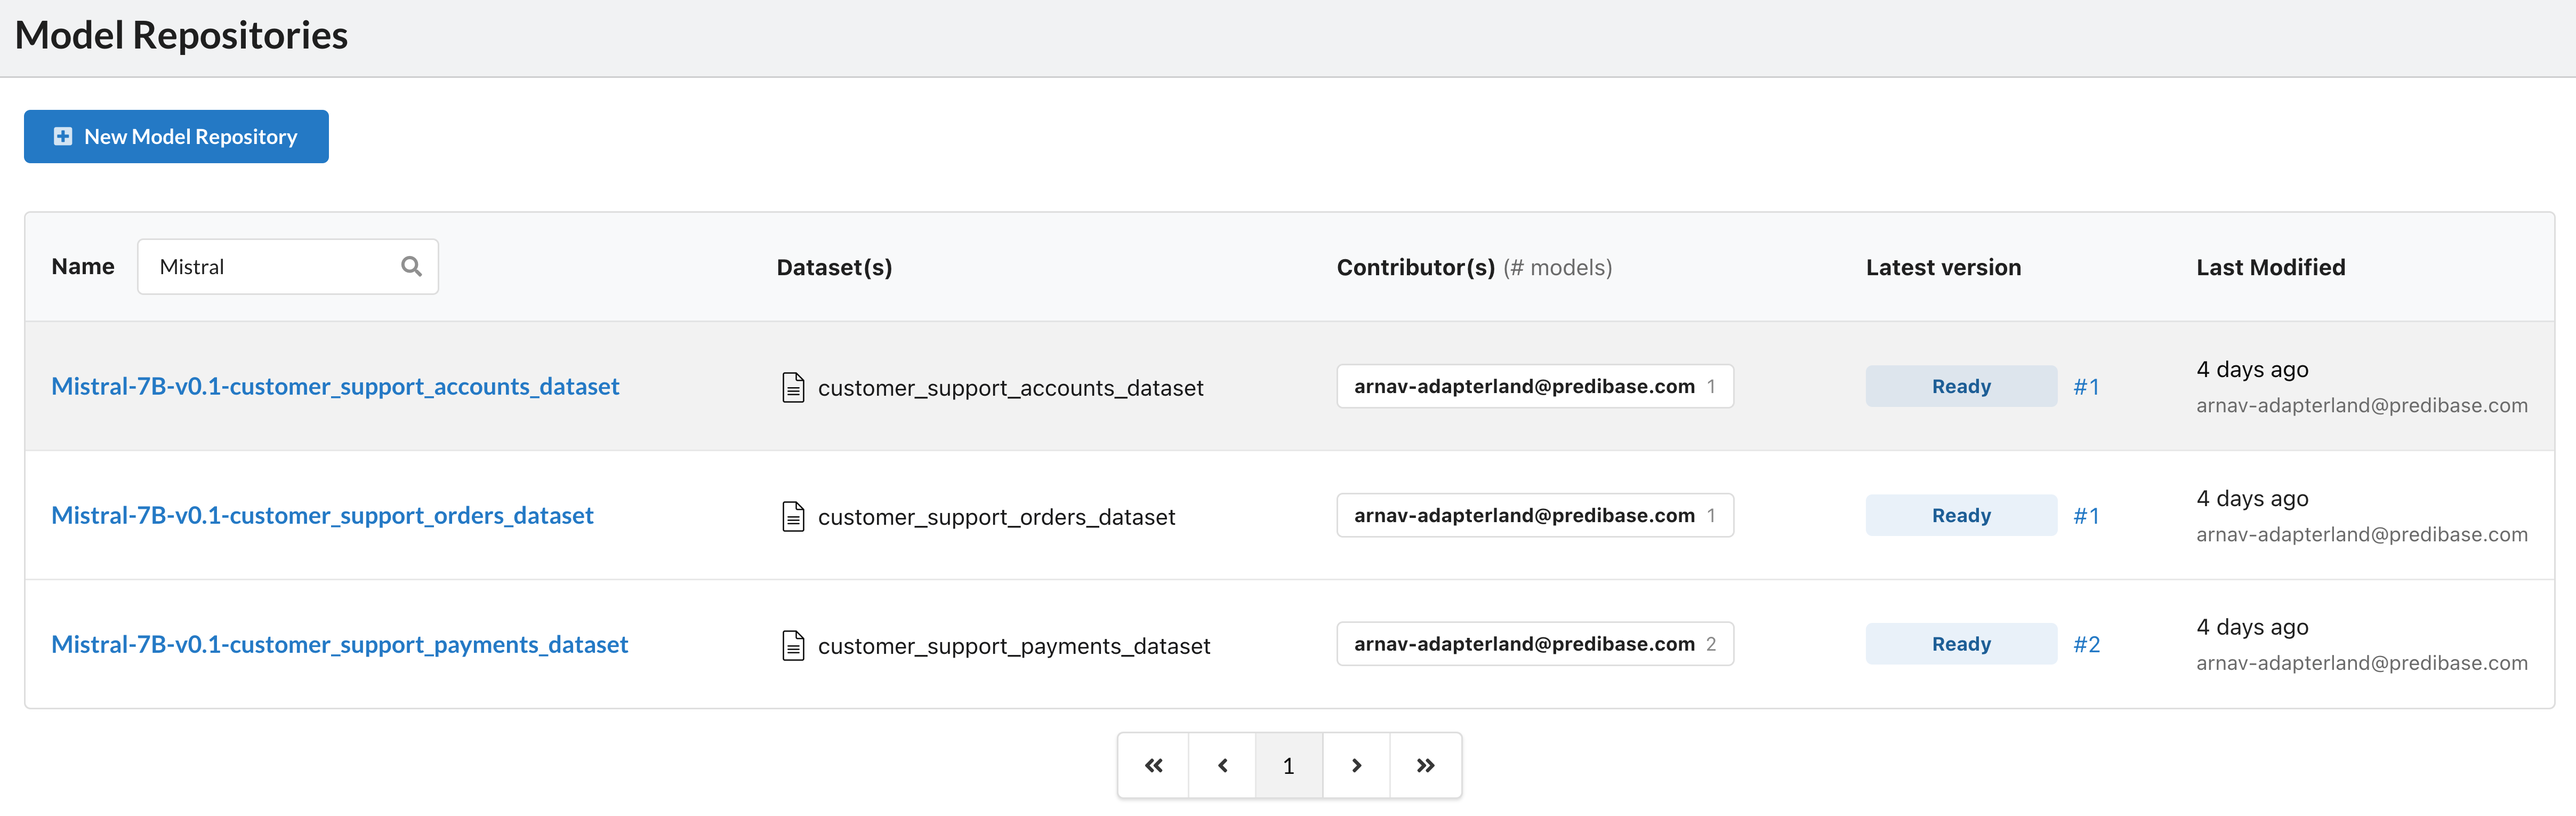

In [ ]:
# Get a reference to the base mistral-7b model we fine-tuned our datasets on
base_llm = pc.LLM("pb://deployments/mistral-7b")

# Option 1: Grab references to the trained models using the repository names (it grabs the latest version automatically)
# payments_model = pc.get_model("Mistral-7B-v0.1-customer_support_payments_dataset")
# orders_model = pc.get_model("Mistral-7B-v0.1-customer_support_orders_dataset")
# accounts_model = pc.get_model("Mistral-7B-v0.1-customer_support_accounts_dataset")

# Option 2: Grab models from HuggingFace
payments_model = pc.LLM("hf://predibase/customer_support_payments")
orders_model = pc.LLM("hf://predibase/customer_support_orders")
accounts_model = pc.LLM("hf://predibase/customer_support_accounts")

# Create LoRAX adapter handles for each model on top of the base model
ft_payments_llm = base_llm.with_adapter(payments_model)
ft_orders_llm = base_llm.with_adapter(orders_model)
ft_accounts_llm = base_llm.with_adapter(accounts_model)

options = {
    "max_new_tokens": 2048, # fine-tuned LLMs actually know how to stop early, so it will not hit the 2048 token limit set here
    "temperature": 0.1
}

Now we can prompt all of these models using the same `generate` method! For now, we'll just spot check them to make sure they have learned something reasonable!

In [ ]:
# Payments Dataset
result = ft_payments_llm.generate(
    """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: check_payment_methods, get_invoice, check_refund_policy, track_refund, payment_issue, check_invoice, get_refund.

    Please package your reply in the JSON format.

    Request: can you help me check in which cases can I ask for refunds?

    Reply:
    """,
    options=options
)
response = result.response
pprint.pprint(json.loads(response))

{'intent': 'check_refund_policy',
 'response': "I'll do my best! I completely understand your need to have a "
             'clear understanding of the situations in which you can request a '
             'refund. Let me provide you with a comprehensive breakdown:\n'
             '\n'
             '1. **Product/Service Defect:** If the product or service you '
             "purchased has a defect or doesn't meet the description, you are "
             'typically eligible for a refund.\n'
             '2. **Cancellation within Grace Period:** Should you change your '
             'mind and decide to cancel your purchase within the specified '
             'grace period, you should be able to receive a refund.\n'
             '3. **Unauthorized Charges:** If you notice any charges on your '
             "account that you didn't authorize or recognize, we will "
             'investigate the matter and assist you in obtaining a refund.\n'
             '4. **Event Cancellation:** If you pu

In [ ]:
# Orders Dataset
result = ft_orders_llm.generate(
    """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: track_order, delivery_options, change_order, cancel_order, set_up_shipping_address, place_order, change_shipping_address', delivery_period.

    Please package your reply in the JSON format.

    Request: I can no longer afford order {{Order Number}}, cancel it

    Reply:
    """,
    options=options
)
response = result.response
pprint.pprint(json.loads(response))

{'intent': 'cancel_order',
 'response': "I've understood you're no longer able to afford order {{Order "
             'Number}} and would like to cancel it. I apologize for any '
             'inconvenience this may have caused. To cancel your order, please '
             'follow these steps:\n'
             '\n'
             '1. Sign in to your account: Access our platform by logging in to '
             'your {{Online Company Portal Info}}.\n'
             "2. Locate your order: Once logged in, navigate to the '{{Online "
             "Order Interaction}}' or '{{Online Order Interaction}}' section.\n"
             '3. Find the specific order: Look for the order with the number '
             '{{Order Number}} and click on it to view the details.\n'
             '4. Initiate cancellation: Within the order details, you should '
             "see an option labeled '{{Online Order Interaction}}'. Please "
             'select this to begin the cancellation process.\n'
             '5. Co

In [ ]:
# Accounts Dataset
result = ft_accounts_llm.generate(
    """
    You are a support agent for a company and you receive requests from customers.
    Your job is to reply to the customer by providing both the intent, which you
    should determine from the customer's request, as well as an appropriate response.

    Please note that the intent can only be one of the following: registration_problems, newsletter_subscription, recover_password, check_cancellation_fee, create_account, switch_account, edit_account, delete_account.

    Please package your reply in the JSON format.

    Request: where can I get information about opening {{Account Category}} accounts?

    Reply:
    """,
    options=options
)
response = result.response
pprint.pprint(json.loads(response))

{'intent': 'create_account',
 'response': "I'll do my best! I'm here to provide you with all the "
             'information you need about opening {{Account Category}} '
             'accounts. You can find detailed information about our {{Account '
             "Category}} accounts on our website's account page. Simply visit "
             "our website and navigate to the account section. There, you'll "
             'find a dedicated page that outlines the benefits, features, and '
             'eligibility criteria for our {{Account Category}} accounts. If '
             'you have any specific questions or need further assistance, feel '
             'free to reach out to our customer support team who will be more '
             "than happy to help you. We're committed to making the account "
             'opening process as smooth and informative as possible for you.'}


# Summary / Takeaways

As can be seen, all of the fine-tuned models:

1. Correctly return a valid JSON response
2. Correctly identify the intent
3. Return a free-form response with smart variable substitution so that it is company agnostic
4. Return relevant and short responses to the request despite a very high max new tokens value.

While we just spot-checked these examples, the fine-tuned models generally do well across entire evaluation sets. Feel free to give them a try after you finish fine-tuning your models!

# Resources
1. Predibase Free Trial: https://predibase.com/free-trial
2. Predibase Docs: https://docs.predibase.com/
3. LoraLand:
  - Demo: https://predibase.com/lora-land
  - Launch Blog: https://predibase.com/blog/lora-land-fine-tuned-open-source-llms-that-outperform-gpt-4
4. More about LoRAX: https://predibase.com/blog/lorax-the-open-source-framework-for-serving-100s-of-fine-tuned-llms-in  